# **Spotify-Insights-Whith-ElasticSearch**

## **Problematica.**
### **Análisis de tendencias musicales a lo largo de los años.**
La música es un reflejo de los cambios culturales, tecnológicos y sociales que ocurren en el mundo. Con el crecimiento de plataformas de streaming como Spotify, hoy en día es posible acceder a grandes volúmenes de datos que describen de forma cuantitativa distintas características de las canciones. Esto abre la puerta al análisis de tendencias musicales de manera más precisa y objetiva.

El presente proyecto tiene como propósito estudiar cómo han evolucionado las características musicales y la popularidad de las canciones a lo largo de los años. A través de un dataset extraído de Spotify, se analizarán atributos como el nivel de energía, bailabilidad, acústica, presencia vocal, intensidad emocional, volumen, duración y tipo de grabación, entre otros. Además, se tomará en cuenta el género musical, el año de lanzamiento y el nivel de popularidad alcanzado por cada canción.

La combinación de estos datos permitirá construir una visión más completa sobre los cambios en las preferencias musicales del público, así como la transformación en los estilos musicales predominantes a lo largo del tiempo. Este análisis busca proporcionar un marco descriptivo sobre la evolución de la música desde una perspectiva cuantitativa y basada en datos reales.


## **Preparación de datos**

Para trabajar de forma cómoda y consistente con los datos del dataset, se realizaron las siguientes acciones:

- Se eliminaron columnas innecesarias como `id` o imágenes de los álbumes.
- Se convirtieron los valores numéricos en notación científica a números de punto flotante para facilitar su análisis.
- Se utilizó la librería `pandas` para leer el archivo `.csv` y convertirlo al formato `.json`, con el fin de subirlo posteriormente a un servidor en ElasticSearch y realizar el análisis correspondiente.


## **Columnas utilizadas en el análisis**

| Columna            | Descripción                                                                 |
|--------------------|-----------------------------------------------------------------------------|
| `artist_name`      | Nombre del artista o banda.                                                 |
| `track_name`       | Nombre de la canción.                                                       |
| `popularity`       | Nivel de popularidad del track (0 a 100), según reproducciones y actividad reciente. |
| `year`             | Año de lanzamiento del track.                                               |
| `genre`            | Género musical del track.                                                   |
| `danceability`     | Qué tan bailable es el track (0.0 a 1.0), considerando ritmo, tempo y estabilidad. |
| `energy`           | Intensidad y actividad de la canción (0.0 a 1.0).                           |
| `loudness`         | Volumen promedio del track en decibelios (dB).                              |
| `mode`             | Modo musical: 1 = Mayor (alegre), 0 = Menor (serio/triste).                 |
| `speechiness`      | Proporción de palabras habladas. 1.0 = hablado, 0.0 = musical.              |
| `acousticness`     | Probabilidad de que el track sea acústico (0.0 a 1.0).                      |
| `instrumentalness` | Probabilidad de que el track no tenga voces (0.0 a 1.0).                    |
| `liveness`         | Probabilidad de que sea una grabación en vivo (0.0 a 1.0).                  |
| `valence`          | Medida de positividad emocional de la música (0.0 a 1.0).                   |
| `duration_ms`      | Duración de la canción en milisegundos.                                     |
| `time_signature`   | Compás musical (por ejemplo, 4 significa 4/4).                              |


## **Proceso del análisis**


### Importación de librerías

A continuación se importan las librerías necesarias para el análisis y manejo de los datos:

- `elasticsearch.Elasticsearch`: Permite conectarse al servidor de ElasticSearch para consultar y gestionar los datos.
- `elasticsearch.helpers`: Ofrece funciones auxiliares para realizar operaciones masivas en ElasticSearch.
- `json`: Se utiliza para manejar datos en formato JSON, necesario al trabajar con ElasticSearch.
- `matplotlib.pyplot`: Se usa para crear gráficos y visualizar los resultados del análisis.
- `collections.Counter`: Facilita el conteo de elementos, útil para contar géneros, años u otras variables categóricas.
- `numpy`: Librería de apoyo para realizar operaciones numéricas.
- `datetime`: Se utiliza para trabajar con fechas.


In [1]:
from elasticsearch import Elasticsearch
from elasticsearch import helpers
import json
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from datetime import datetime

# **Class ElasticSearchProvider**
La clase `ElasticSearchProvider` permite conectarse a un servidor de **Elasticsearch**, utilizando un índice llamado **"spotify-insights"**. 
### Características principales:
- **Conexión a Elasticsearch**: Establece una conexión con el servidor Elasticsearch en el host especificado (por defecto, el puerto: `9200`).
- **Gestión de la conexión**: Implementa un contexto de entrada y salida (`__enter__` y `__exit__`) para abrir y cerrar automáticamente la conexión, lo que asegura que no se quede abierta después de su uso.
- **index**: La clase está configurada para interactuar con un índice específico llamado `"spotify-insights"`, que se utiliza para almacenar los datos.
### Funcionalidad adicional:
Aunque el código proporcionado no incluye la lógica para leer un archivo de texto o JSON, se podría extender para agregar la funcionalidad de cargar datos desde un archivo y almacenarlos en Elasticsearch, por ejemplo, para registrar información sobre canciones, usuarios, o cualquier otro tipo de datos relacionados con Spotify.


In [2]:
class ElasticSearchProvider:

    def __init__(self):
        self.host = "http://localhost:9200"
        #self.user = str(user)
        #self.password = str(password)
        self.index = "spotify-insights"
        self.index_type ="_doc"
        self.connection = Elasticsearch(self.host)

    def __enter__(self):
        try:
            self.connection=Elasticsearch(self.host)
            return self
        except Exception as e:
            return{
                "StatusCode":500,
                "body":json.dumps({
                    "Message":str(e)
                })
            }

    def __exit__(self, exception_type, exception_value, traceback):
        self.connection.transport.close()


# **Lista de consultas**


## **1.- Top 10 canciones más populares por género:**
La siguiente función realiza una consulta a Elasticsearch para obtener la siguiente información:

1. **Top 10 géneros más populares**: Se realiza una agregación para obtener los 10 géneros más populares, basándose en el campo `genre`. Los géneros se ordenan por su frecuencia en los documentos, lo que asegura que se obtienen los más populares.
2. **Top 10 canciones por género**: Para cada uno de los géneros populares, se realiza una sub-agregación (`top_hits`) para recuperar las 10 canciones más populares, obteniendo los siguientes campos para cada canción:
   - `track_name`: Nombre de la canción.
   - `artist_name`: Nombre del artista.
   - `popularity`: Popularidad de la canción.

Además, como la función está fuera de la clase `ElasticSearchProvider`, la última línea de código asigna la función a la clase de forma dinámica, lo que garantiza que funcione correctamente sin generar errores, incluso si la función no fue definida originalmente dentro de la clase.

In [3]:
def showMostPopularbyGenre(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "aggs": {
                        "top_genres": {
                        "terms": {
                            "field": "genre",
                            "size": 10
                        },
                        "aggs": {
                            "top_tracks": {
                            "top_hits": {
                                "size": 10,
                                "_source": ["track_name", "artist_name", "popularity"]
                                }
                            }
                        }
                    }
                }
            }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")

ElasticSearchProvider.showMostPopularbyGenre=showMostPopularbyGenre

## **Visualización**
El siguiente código es una instancia de la funcion anteriormente mostrada lo cual nos permite otener la respuesta del servidor en un formato JSON y a su vez la visualización con gráficos de pastel.

### Descripción de la respuesta:
1. Se obtienen los géneros y canciones más populares.
2. Se crean gráficos de pastel para cada género, mostrando la distribución de popularidad de los 10 tracks principales.


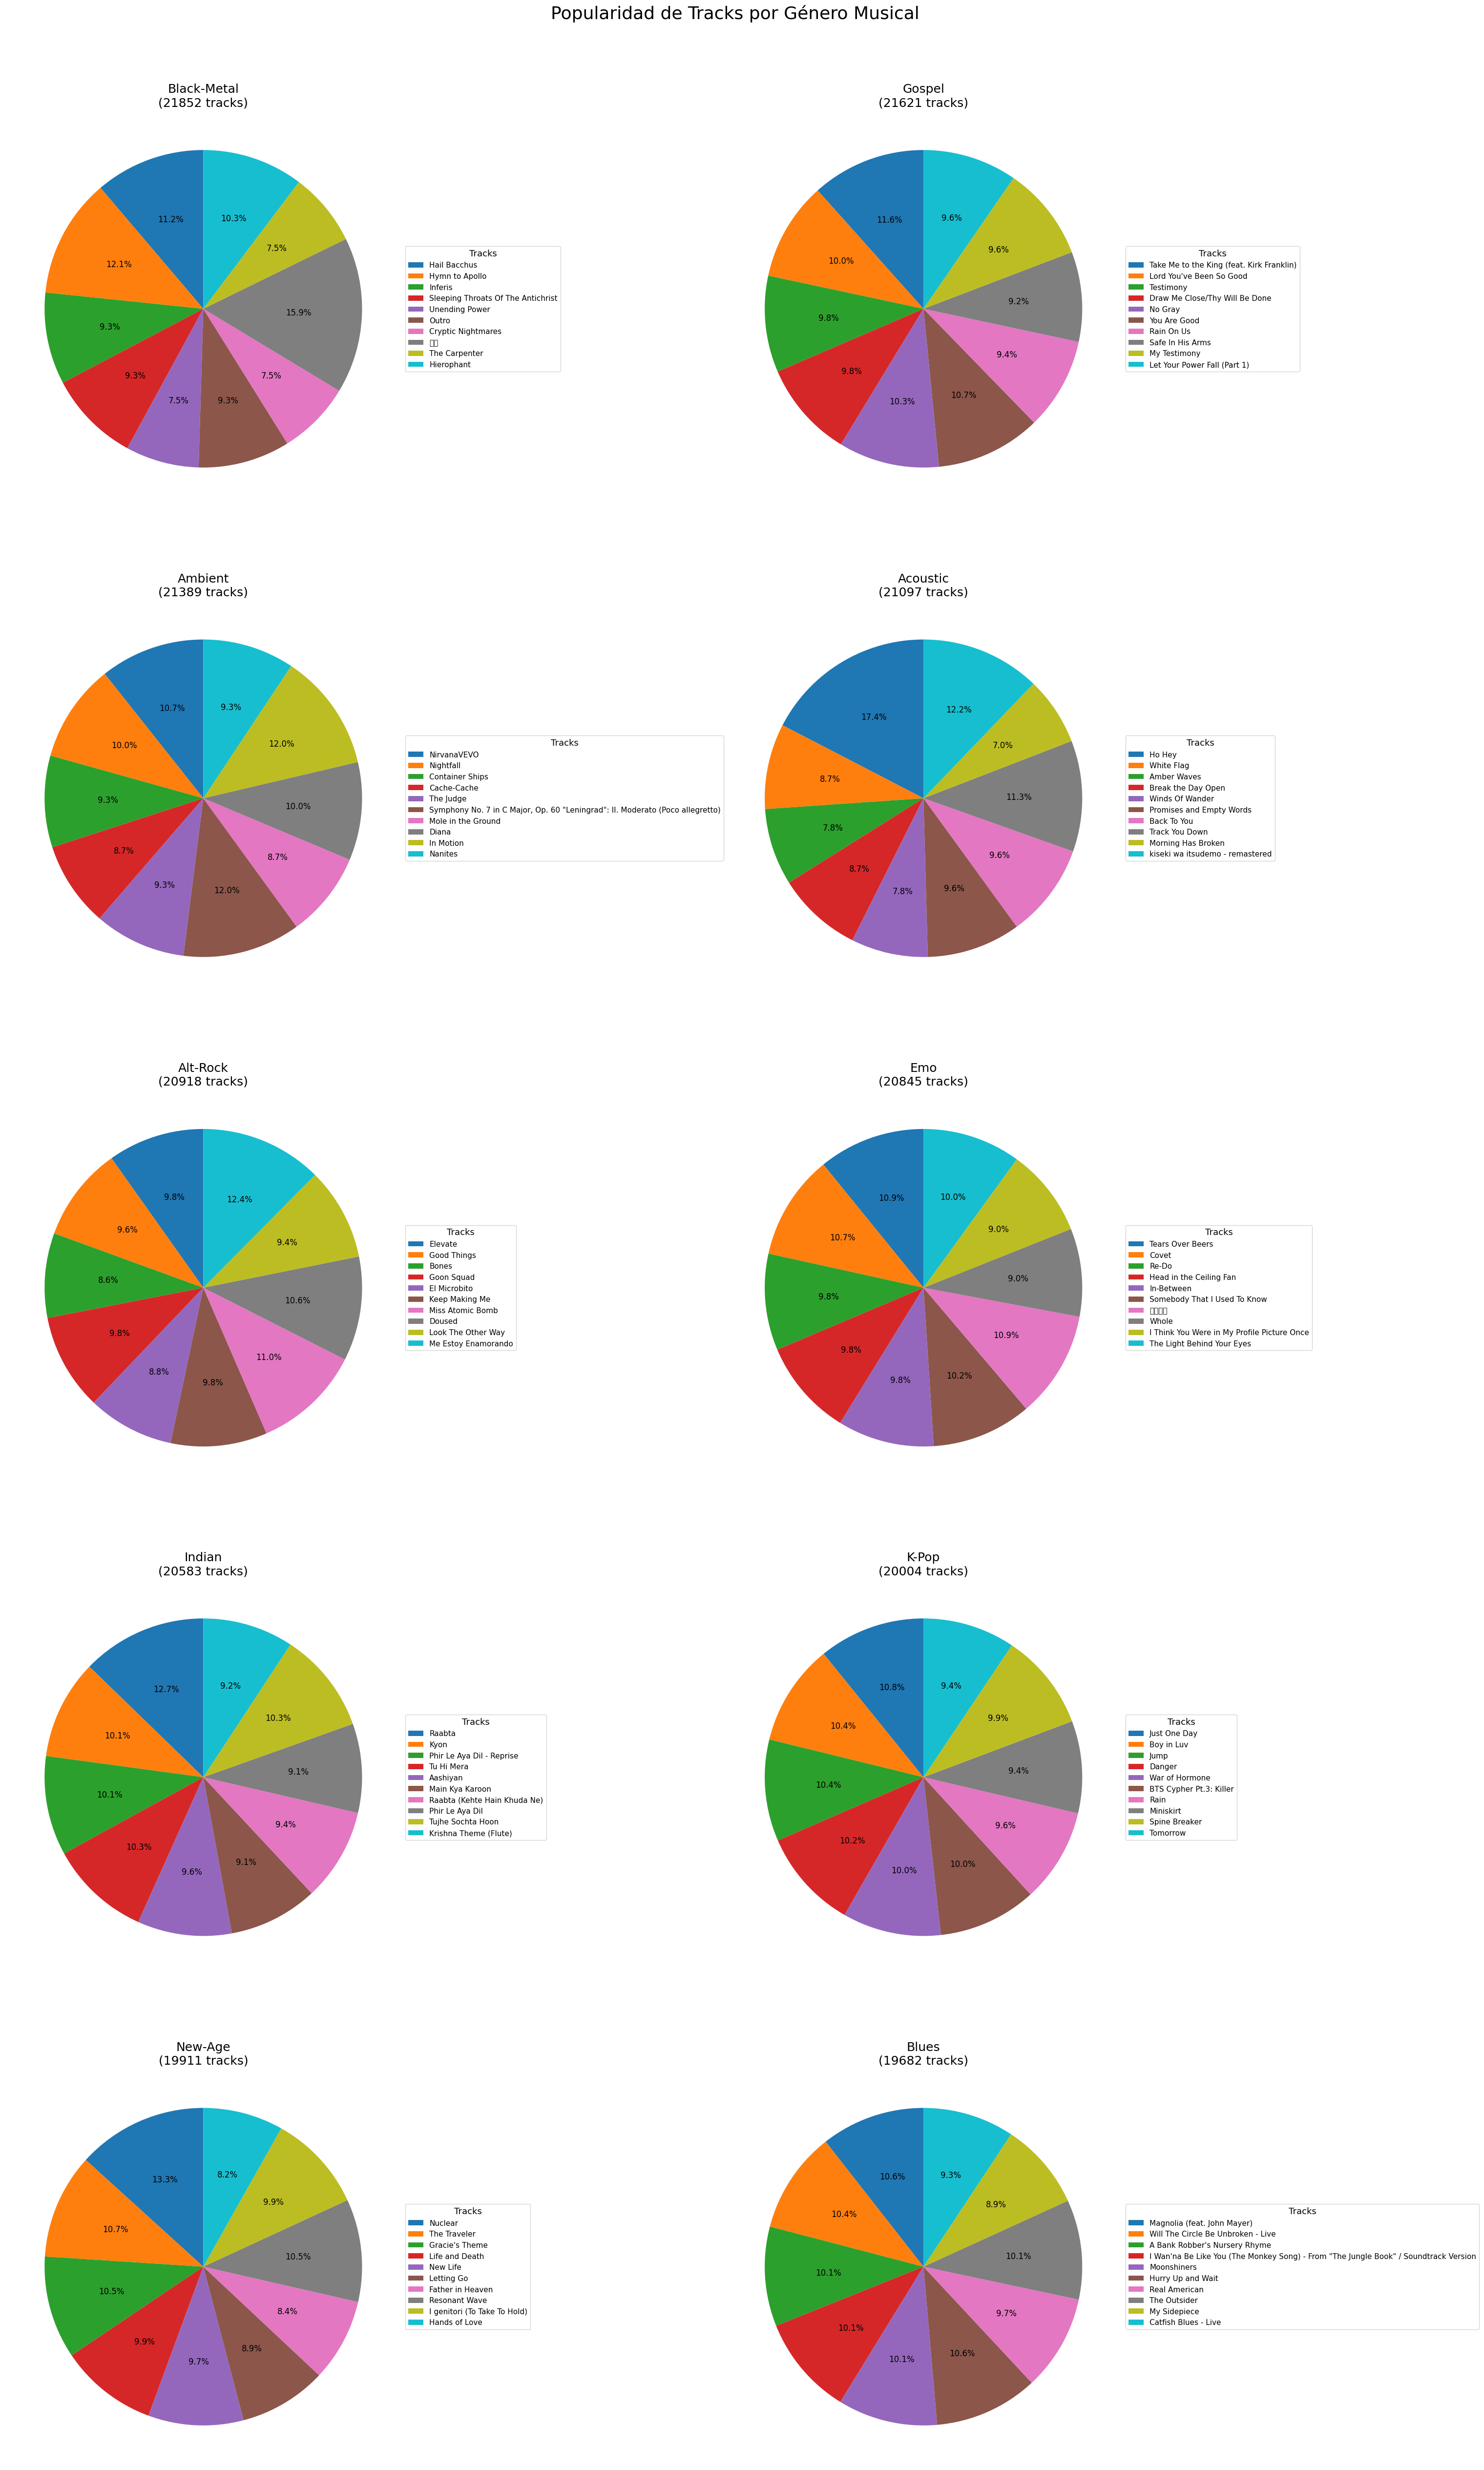

In [5]:
provider = ElasticSearchProvider()
response = provider.showMostPopularbyGenre()
data = response['aggregations']['top_genres']['buckets']
n_genres = len(data)
cols = 2  # Menos columnas para gráficas más grandes
rows = int(np.ceil(n_genres / cols))

fig = plt.figure(figsize=(30, 10 * rows), constrained_layout=True)
fig.suptitle('Popularidad de Tracks por Género Musical', fontsize=26, y=1.02)

for i, genre in enumerate(data, 1):
    genre_name = genre['key']
    tracks = genre['top_tracks']['hits']['hits'][:10]

    track_names = [t['_source']['track_name'] for t in tracks]
    popularities = [t['_source']['popularity'] for t in tracks]
    ax = fig.add_subplot(rows, cols, i)

    wedges, texts, autotexts = ax.pie(
        popularities,
        labels=None,  # Evitamos etiquetas dentro del pastel
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 12}
    )

    # Leyenda más grande
    ax.legend(
        wedges,
        track_names,
        title="Tracks",
        title_fontsize=13,
        fontsize=11,
        loc='center left',
        bbox_to_anchor=(1, 0.5)
    )

    ax.set_title(f"{genre_name.title()}\n({genre['doc_count']} tracks)", fontsize=18)

plt.show()

## **2.- Top 5 canciones más populares de un artista específico**

La siguiente función realiza una consulta a Elasticsearch para obtener la información sobre las canciones más populares de un artista específico.

### Descripción:
1. Obtiene las **5 canciones más populares** de un artista, basándose en el nombre del artista proporcionado.
2. La función también asigna dinámicamente la función a la clase `ElasticSearchProvider` para garantizar que funcione correctamente, aunque no haya sido definida originalmente dentro de la clase.


In [ ]:
def showMostPopularbyArtist(self,name):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 5,
                    "query": {
                        "match": {
                        "artist_name": name 
                        }
                    },
                    "aggs": {
                        "top_tracks": {
                        "terms": {
                            "field": "track_name.keyword",  
                        },
                        "aggs": {
                            "popular_tracks": {
                            "top_hits": {
                                "size": 5,
                                "_source": ["track_name", "popularity"]
                            }
                            }
                        }
                        }
                    }
                }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
            
ElasticSearchProvider.showMostPopularbyArtist=showMostPopularbyArtist

## **Visualización**
El siguiente código es una instancia de la funcion anteriormente mostrada lo cual nos permite otener la respuesta del servidor en un formato JSON, pero a su vez debemos pasarle el nombre de un artista el cual se escribe en la variable `name` y despues podemos ver la visualización en un gráfico de barras horizontal.



Respuesta obtenida:


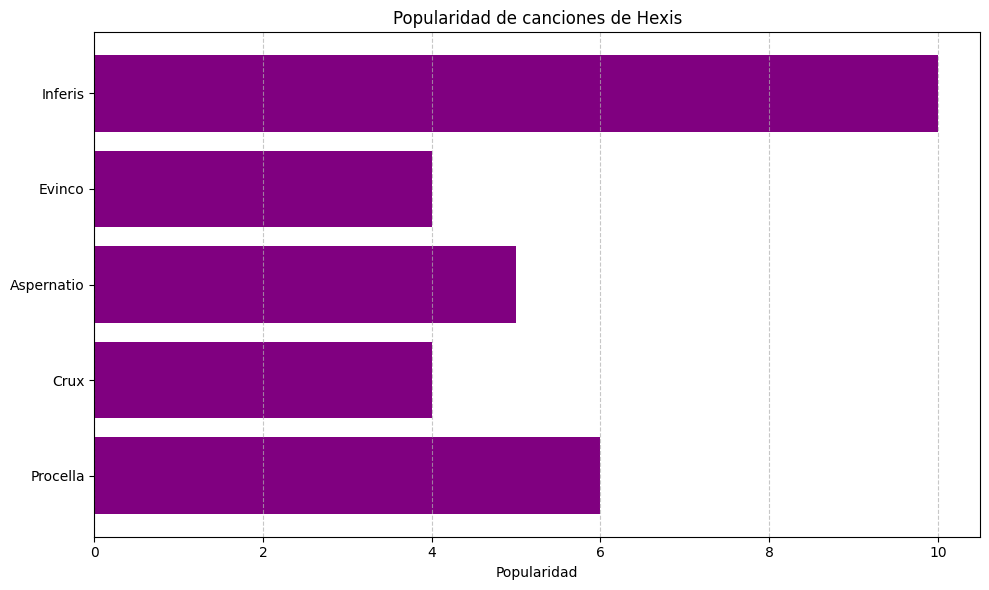

In [49]:
provider = ElasticSearchProvider()
name="Hexis"
response = provider.showMostPopularbyArtist(name)

if response:
    print("Respuesta obtenida:")
    hits = response["hits"]["hits"]
    canciones = []
    popularidades = []
    for hit in hits:
        source = hit["_source"]
        track_name = source.get("track_name", "Desconocido")
        popularity = source.get("popularity", 0)
        canciones.append(track_name)
        popularidades.append(popularity)

    plt.figure(figsize=(10, 6))
    plt.barh(canciones, popularidades, color='purple')
    plt.xlabel('Popularidad')
    plt.title(f'Popularidad de canciones de {name}')
    plt.gca().invert_yaxis()  
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

else:
    print("No se obtuvo respuesta válida.")


## **3.- Promedio de la popularidad por género**

La siguiente función realiza una consulta a Elasticsearch para obtener el promedio de popularidad por género.

### Descripción:
1. Calcula el **promedio de popularidad** para los 20 géneros más populares.
2. La función asigna dinámicamente el método a la clase `ElasticSearchProvider` para asegurar que funcione correctamente.


In [23]:
def showMostPopularGenrebyYear(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "aggs": {
                        "avg_popularity_by_genre": {
                        "terms": {
                            "field": "genre",
                            "size": 20
                        },
                        "aggs": {
                            "avg_popularity": {
                            "avg": {
                                "field": "popularity"
                            }
                            }
                        }
                        }
                    }
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")

ElasticSearchProvider.showMostPopularGenrebyYear=showMostPopularGenrebyYear

## **Visualización del promedio de popularidad por género**

Esta instancia obtiene el promedio de popularidad por género y lo visualiza en un gráfico de barras horizontales.

### Descripción:
1. Extrae los géneros y sus respectivas popularidades promedio desde la respuesta de Elasticsearch.
2. Visualiza los datos con un gráfico de barras horizontales, ordenando los géneros más populares en la parte superior.


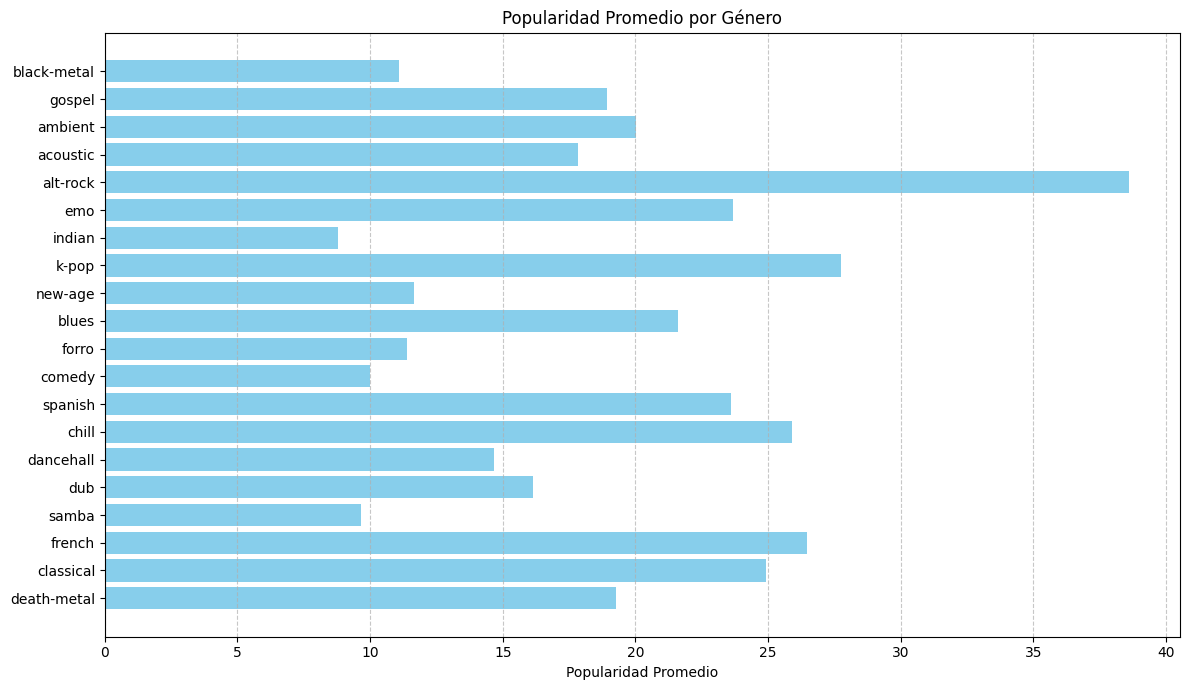

In [24]:
provider = ElasticSearchProvider()

response = provider.showMostPopularGenrebyYear()
if response:
    buckets = response["aggregations"]["avg_popularity_by_genre"]["buckets"]
    generos = []
    popularidad_promedio = []

    for bucket in buckets:
        generos.append(bucket["key"])
        popularidad_promedio.append(bucket["avg_popularity"]["value"])

    plt.figure(figsize=(12, 7))
    plt.barh(generos, popularidad_promedio, color='skyblue')
    plt.xlabel('Popularidad Promedio')
    plt.title('Popularidad Promedio por Género')
    plt.gca().invert_yaxis() 
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

else:
    print("No se obtuvo respuesta válida.")

## **4.- Top 5 géneros más populares en un año específico**

La función obtiene los 5 géneros más populares en un año determinado, calculando la popularidad promedio de las canciones por género en ese año.

### Proceso:
1. Filtra los datos por el año específico.
2. Realiza una agregación para obtener los 5 géneros más populares.
3. Calcula la popularidad promedio de las canciones por género.
4. La función asigna dinámicamente el método a la clase `ElasticSearchProvider` para asegurar que funcione correctamente.


In [10]:
def showMostPopularGenrebySpecificYear(self,year):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "query": {
                        "term": {
                        "year": year
                        }
                    },
                    "aggs": {
                        "top_genres": {
                        "terms": {
                            "field": "genre",
                            "size": 5
                        },
                        "aggs": {
                            "avg_popularity": {
                            "avg": {
                                "field": "popularity"
                            }
                            }
                        }
                        }
                    }
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
ElasticSearchProvider.showMostPopularGenrebySpecificYear=showMostPopularGenrebySpecificYear

## **Visualización**

Este código genera un gráfico de barras horizontales mostrando los 5 géneros más populares en un año específico y su popularidad promedio.

1. Se obtiene la respuesta de la función `showMostPopularGenrebySpecificYear` para un año determinado.
2. Se procesan los géneros y su popularidad promedio.
3. Se visualizan los resultados en un gráfico de barras horizontales.


C:\Users\Manuel\AppData\Local\Temp\ipykernel_6416\4290099307.py:14: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  year_readable = datetime.utcfromtimestamp(year / 1000).strftime('%Y')


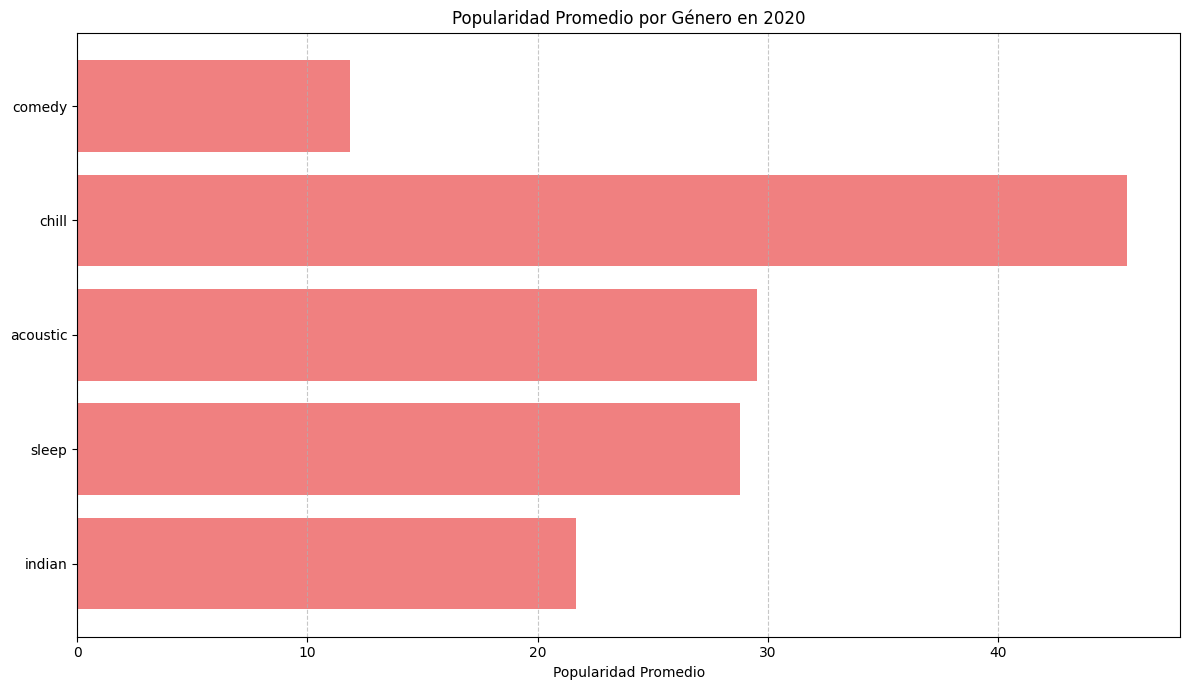

In [17]:
provider = ElasticSearchProvider()
year=1577836800000

response = provider.showMostPopularGenrebySpecificYear(year)
if response:
    buckets = response["aggregations"]["top_genres"]["buckets"]
    generos = []
    popularidad_promedio = []

    for bucket in buckets:
        generos.append(bucket["key"])
        popularidad_promedio.append(bucket["avg_popularity"]["value"])

    year_readable = datetime.utcfromtimestamp(year / 1000).strftime('%Y')

    plt.figure(figsize=(12, 7))
    plt.barh(generos, popularidad_promedio, color='lightcoral')
    plt.xlabel('Popularidad Promedio')
    plt.title(f'Popularidad Promedio por Género en {year_readable}')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

else:
    print("No se obtuvo respuesta válida.")

## **5. Top 10 canciones con la mayor energía de un artista especifico**

Busca en Elasticsearch las 10 canciones con más energía, ordenadas de mayor a menor.  
Solo muestra el nombre de la canción, el artista y el nivel de energía.

La función asigna dinámicamente el método a la clase `ElasticSearchProvider` para asegurar que funcione correctamente.

In [17]:
def showSongsWhittheMostEnegy(self, artist_name):
    try:
        response = self.connection.search(
            index=self.index,
            body={
                "query": {
                    "term": {
                        "artist_name": {
                            "value": artist_name
                        }
                    }
                },
                "size": 0,
                "aggs": {
                    "top_energy_songs": {
                        "top_hits": {
                            "size": 10,
                            "_source": ["track_name", "artist_name", "energy"],
                            "sort": [
                                {
                                    "energy": {
                                        "order": "desc"
                                    }
                                }
                            ]
                        }
                    }
                }
            }
        )
        return response

    except Exception as e:
        print(f"Error: {str(e)}")

ElasticSearchProvider.showSongsWhittheMostEnegy = showSongsWhittheMostEnegy


## **Visualización**

Este código genera un gráfico de barras horizontales mostrando las 10 canciones con más energía.
Donde el artista especifico se define en la variable name.


1. Se procesa el resultado obtenido de ElasticSearch.
2. Se visualizan los resultados en un gráfico de barras horizontales.


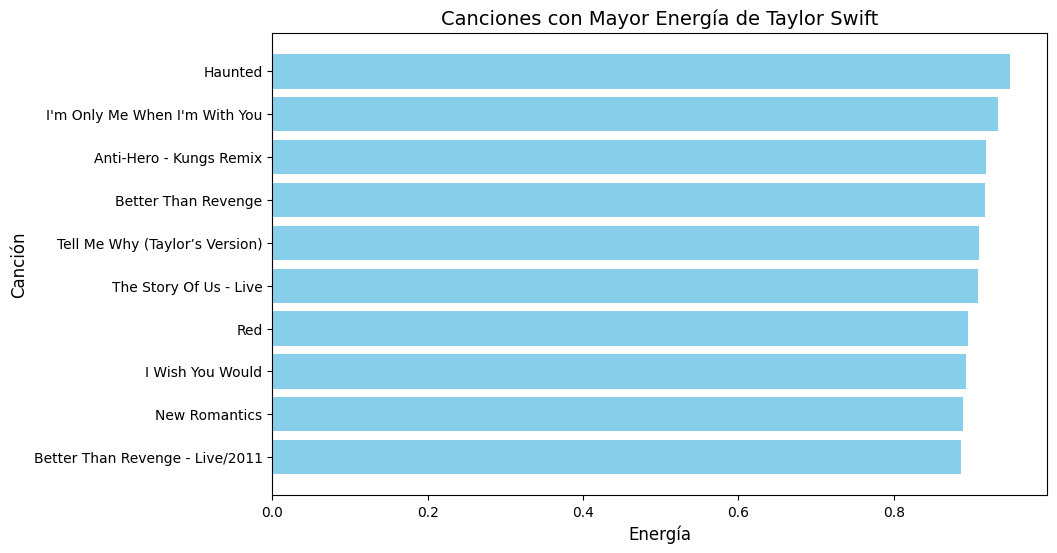

In [ ]:
provider = ElasticSearchProvider()
artist_name = "Taylor Swift"

response = provider.showSongsWhittheMostEnegy(artist_name=artist_name)

if response and "aggregations" in response:
    songs = response["aggregations"]["top_energy_songs"]["hits"]["hits"]
    tracks = [song["_source"]["track_name"] for song in songs]
    energies = [song["_source"]["energy"] for song in songs]

    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.barh(tracks, energies, color='skyblue')
    plt.title(f'Canciones con Mayor Energía de {artist_name}', fontsize=14)
    plt.xlabel('Energía', fontsize=12)
    plt.ylabel('Canción', fontsize=12)
    plt.gca().invert_yaxis()  
    plt.show()

else:
    print("No se obtuvo respuesta válida.")


## **6. Top 10 canciones más "acústicas"**

Busca en **Elasticsearch** las 10 canciones con mayor nivel de *acousticness* (acústica), ordenadas de mayor a menor.  
Solo muestra el nombre de la canción, el artista y el nivel de *acousticness*.

La función asigna dinámicamente el método a la clase `ElasticSearchProvider` para asegurar que funcione correctamente.


In [ ]:
def showSongsWhitMostAcustic(self, genre):
    try:
        response = self.connection.search(
            index=self.index,
            body={
                "query": {
                    "term": {
                        "genre": genre
                    }
                },
                "size": 0,
                "aggs": {
                    "top_acoustic_songs": {
                        "top_hits": {
                            "size": 10,
                            "_source": ["track_name", "artist_name", "acousticness"],
                            "sort": [
                                {
                                    "acousticness": {
                                        "order": "desc"
                                    }
                                }
                            ]
                        }
                    }
                }
            }
        )
        return response

    except Exception as e:
        print(f"Error: {str(e)}")

ElasticSearchProvider.showSongsWhitMostAcustic = showSongsWhitMostAcustic


## **Visualización**

Este código genera un gráfico de barras horizontales mostrando las 10 canciones mas acusticas.


1. Se procesa el resultado obtenido de ElasticSearch.
2. Se visualizan los resultados en un gráfico de barras horizontales.


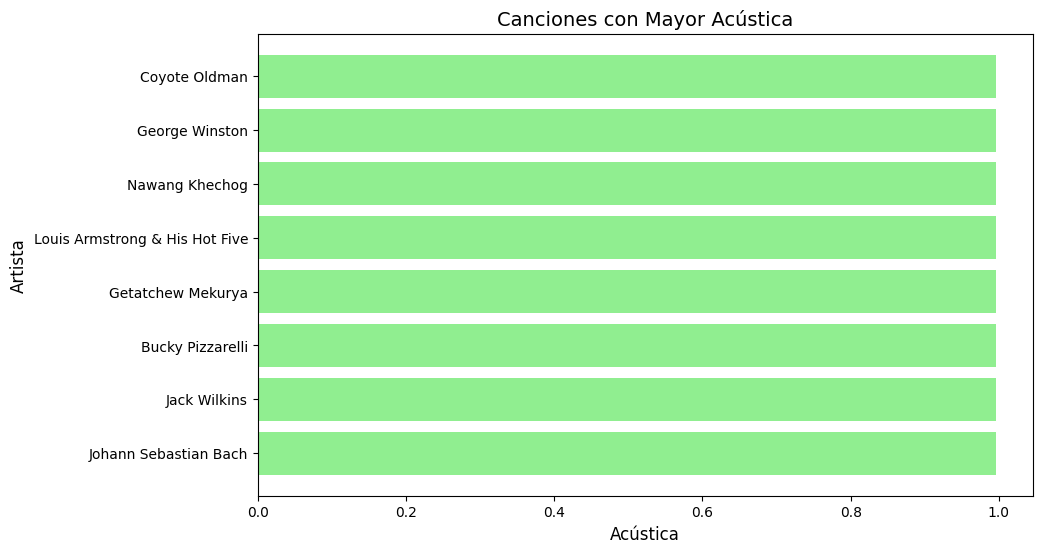

In [30]:
provider = ElasticSearchProvider()
response = provider.showSongsWhitMostAcustic()
if response:
    songs = response["aggregations"]["top_acoustic_songs"]["hits"]["hits"]
    artists = [song["_source"]["artist_name"] for song in songs]
    tracks = [song["_source"]["track_name"] for song in songs]
    acousticness_values = [song["_source"]["acousticness"] for song in songs]
    plt.figure(figsize=(10, 6))
    plt.barh(artists, acousticness_values, color='lightgreen')
    plt.title('Canciones con Mayor Acústica', fontsize=14)
    plt.xlabel('Acústica', fontsize=12)
    plt.ylabel('Artista', fontsize=12)

    plt.show()
else:
    print("No se obtuvo respuesta válida.")

## **7. Promedio de "valence" por año**

Busca en **Elasticsearch** el promedio del valor de *valence* para cada año, ordenado por el año.  
Solo muestra el año y el promedio de *valence*.

La función asigna dinámicamente el método a la clase `ElasticSearchProvider` para asegurar que funcione correctamente.


In [15]:
def showPromValencebyYear(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "aggs": {
                        "avg_valence_by_year": {
                        "terms": {
                            "field": "year",
                            "size": 10000  
                        },
                        "aggs": {
                            "avg_valence": {
                            "avg": {
                                "field": "valence"
                            }
                            }
                        }
                        }
                    }
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
            
ElasticSearchProvider.showPromValencebyYear=showPromValencebyYear

## **Visualización**

Este código genera un gráfico el cual nos muestra la valencia y su escalada por año

1. Se procesa el resultado obtenido de ElasticSearch.
2. Se visualizan los resultados en un gráfico.


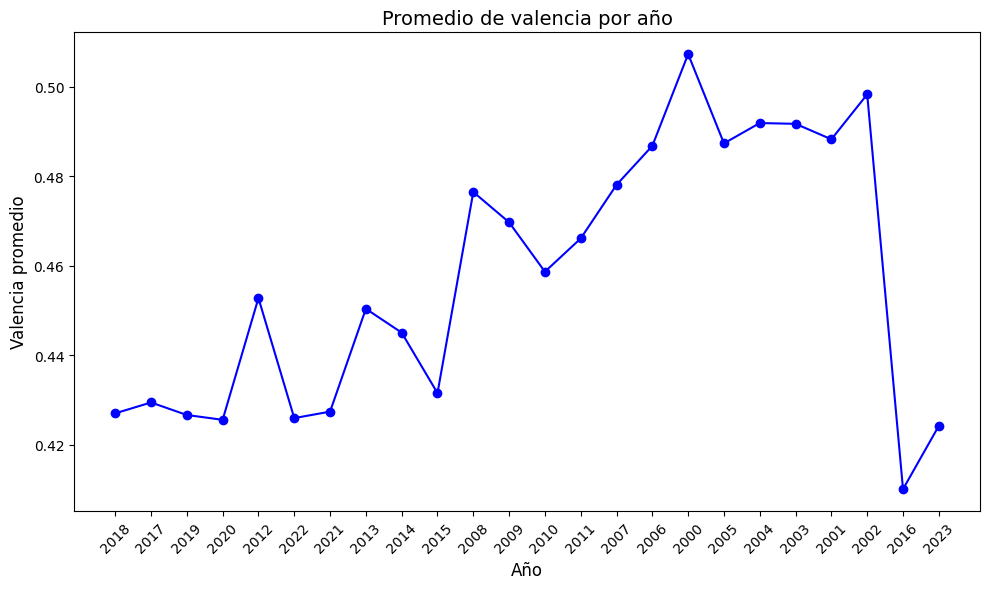

In [16]:
provider = ElasticSearchProvider()
response = provider.showPromValencebyYear()
if response:
    years = [bucket['key_as_string'] for bucket in response['aggregations']['avg_valence_by_year']['buckets']]
    valence_values = [bucket['avg_valence']['value'] for bucket in response['aggregations']['avg_valence_by_year']['buckets']]
    plt.figure(figsize=(10, 6))
    plt.plot(years, valence_values, marker='o', linestyle='-', color='b')
    plt.title('Promedio de valencia por año', fontsize=14)
    plt.xlabel('Año', fontsize=12)
    plt.ylabel('Valencia promedio', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

## **8. Distribución de las canciones por "mode" (mayoría mayor o menor)**

Busca en **Elasticsearch** la distribución de canciones según el campo *mode* (mayoría mayor o menor), mostrando la cantidad de canciones para cada valor de *mode*.

Solo muestra el valor de *mode* y la cantidad de canciones correspondientes.

La función asigna dinámicamente el método a la clase `ElasticSearchProvider` para asegurar que funcione correctamente.


In [33]:
def showModebySongs(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "aggs": {
                        "mode_distribution": {
                        "terms": {
                            "field": "mode",
                            "size": 10
                        },
                        "aggs": {
                            "count_by_mode": {
                            "value_count": {
                                "field": "mode"
                            }
                            }
                        }
                        }
                    }
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")

ElasticSearchProvider.showModebySongs=showModebySongs

## **Visualización**

Este código genera un gráfico de pastel el cual nos muestra la distribucion de alegria o tristeza en las canciones utilizando la columna mode.

1. Se procesa el resultado obtenido de ElasticSearch.
2. Se visualizan los resultados en un gráfico de pastel.


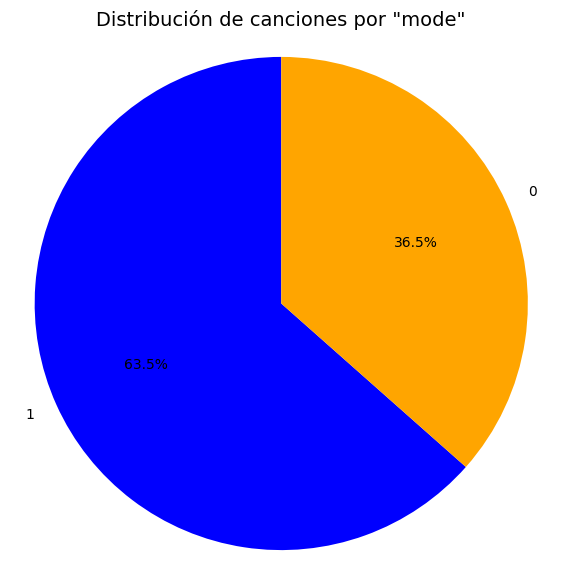

In [34]:
provider = ElasticSearchProvider()
response = provider.showModebySongs()
if response:
    modes = [bucket['key'] for bucket in response['aggregations']['mode_distribution']['buckets']]
    song_counts = [bucket['doc_count'] for bucket in response['aggregations']['mode_distribution']['buckets']]
    plt.figure(figsize=(7, 7))
    plt.pie(song_counts, labels=modes, autopct='%1.1f%%', colors=['blue', 'orange'], startangle=90)
    plt.title('Distribución de canciones por "mode"', fontsize=14)
    plt.axis('equal')
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

## **9. Promedio de duración de canciones por género**

Busca en **Elasticsearch** el promedio de duración de las canciones por género, mostrando la duración promedio para cada género.

Solo muestra el género y el promedio de duración en milisegundos.

La función asigna dinámicamente el método a la clase `ElasticSearchProvider` para asegurar que funcione correctamente.


In [35]:
def showDurationBySongs(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "aggs": {
                        "genres": {
                        "terms": {
                            "field": "genre",  
                            "size": 20
                        },
                        "aggs": {
                            "avg_duration": {
                            "avg": {
                                "field": "duration_ms" 
                            }
                            }
                        }
                        }
                    }
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
            
ElasticSearchProvider.showDurationBySongs=showDurationBySongs

## **Visualización**

Este código genera un gráfico que nos permite visualizar la variacion entre duración de las canciones de cada genero.

1. Se procesa el resultado obtenido de ElasticSearch.
2. Se visualizan los resultados en un gráfico.


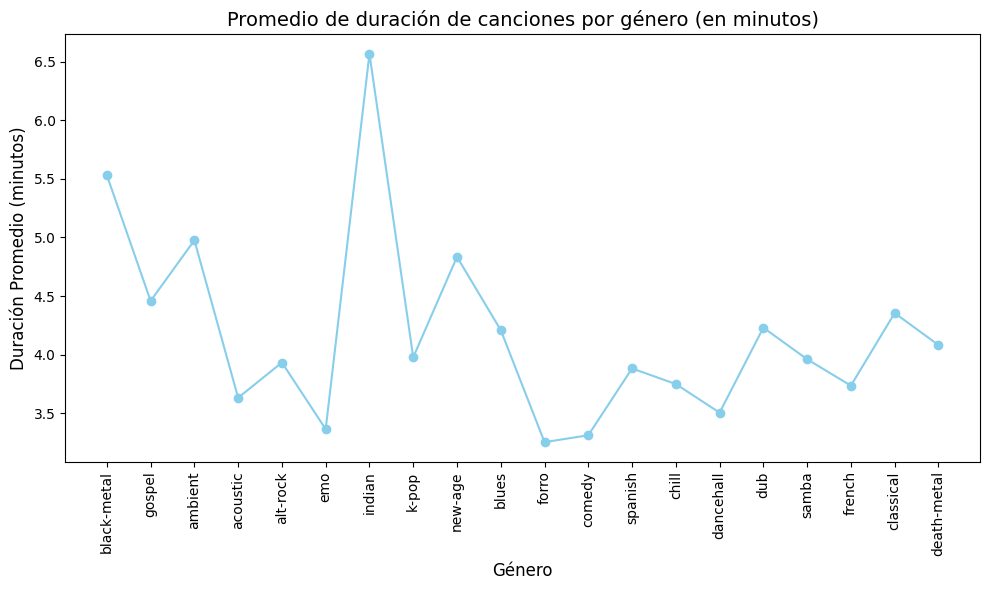

In [36]:
provider = ElasticSearchProvider()
response = provider.showDurationBySongs()
if response:
    genres = [bucket['key'] for bucket in response['aggregations']['genres']['buckets']]
    durations = [bucket['avg_duration']['value'] for bucket in response['aggregations']['genres']['buckets']]
    durations_minutes = [duration / 60000 for duration in durations]
    plt.figure(figsize=(10, 6))
    plt.plot(genres, durations_minutes, marker='o', linestyle='-', color='skyblue')
    plt.title('Promedio de duración de canciones por género (en minutos)', fontsize=14)
    plt.xlabel('Género', fontsize=12)
    plt.ylabel('Duración Promedio (minutos)', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

## **10. Top 10 canciones más "loudness"**

Busca en **Elasticsearch** las 10 canciones con mayor nivel de *loudness* (volumen), ordenadas de mayor a menor.

Solo muestra el nombre de la canción, el artista y el nivel de *loudness*.

La función asigna dinámicamente el método a la clase `ElasticSearchProvider` para asegurar que funcione correctamente.


In [37]:
def showSongsWhitMostLoud(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 10,
                    "sort": [
                        {
                        "loudness": {
                            "order": "desc"  
                        }
                        }
                    ],
                    "_source": ["track_name", "artist_name", "loudness"]  
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
            
ElasticSearchProvider.showSongsWhitMostLoud=showSongsWhitMostLoud

## **Visualización**

Este código genera un gráfico de barras que nos muestra las canciones mas ruidosas utilizando el loudnes que es el promedio de dbs de las canciones.


1. Se procesa el resultado obtenido de ElasticSearch.
2. Se visualizan los resultados en un gráfico de barras verticales.


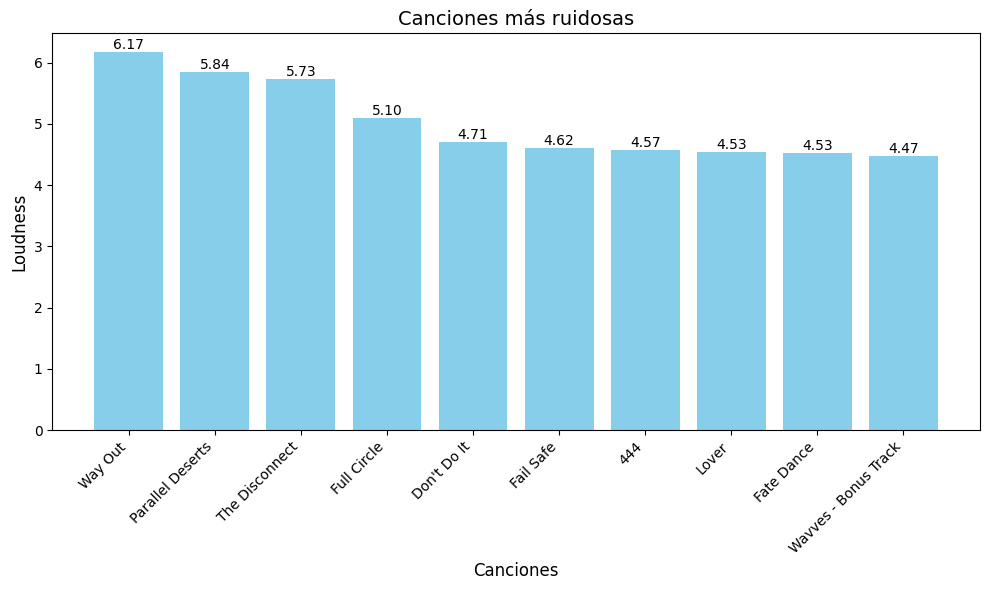

In [38]:
provider = ElasticSearchProvider()
response = provider.showSongsWhitMostLoud()
if response:
    songs = [hit['_source']['track_name'] for hit in response['hits']['hits']]
    artists = [hit['_source']['artist_name'] for hit in response['hits']['hits']]
    loudness = [hit['_source']['loudness'] for hit in response['hits']['hits']]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(songs, loudness, color='skyblue')
    plt.title('Canciones más ruidosas', fontsize=14)
    plt.xlabel('Canciones', fontsize=12)
    plt.ylabel('Loudness', fontsize=12)
    plt.xticks(rotation=45, ha='right') 

    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                f'{bar.get_height():.2f}', va='bottom', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

## **11. Top 10 canciones con mayor "speechiness"**

Busca en **Elasticsearch** las 10 canciones con mayor nivel de *speechiness* (presencia de voz o discurso), ordenadas de mayor a menor.

Solo muestra el nombre de la canción, el artista y el nivel de *speechiness*.

La función asigna dinámicamente el método a la clase `ElasticSearchProvider` para asegurar que funcione correctamente.


In [39]:
def showSongsWhitMostSpeech(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 10,
                    "sort": [
                        {
                        "speechiness": {
                            "order": "desc"  
                        }
                        }
                    ],
                    "_source": ["track_name", "artist_name", "speechiness"] 
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
            
ElasticSearchProvider.showSongsWhitMostSpeech=showSongsWhitMostSpeech

## **Visualización**

Este código genera un gráfico de barras horizontales que nos muestra las canciones que tienen mas palabras por minuto.

1. Se procesa el resultado obtenido de ElasticSearch.
2. Se visualizan los resultados en un gráfico de barras horizontales.


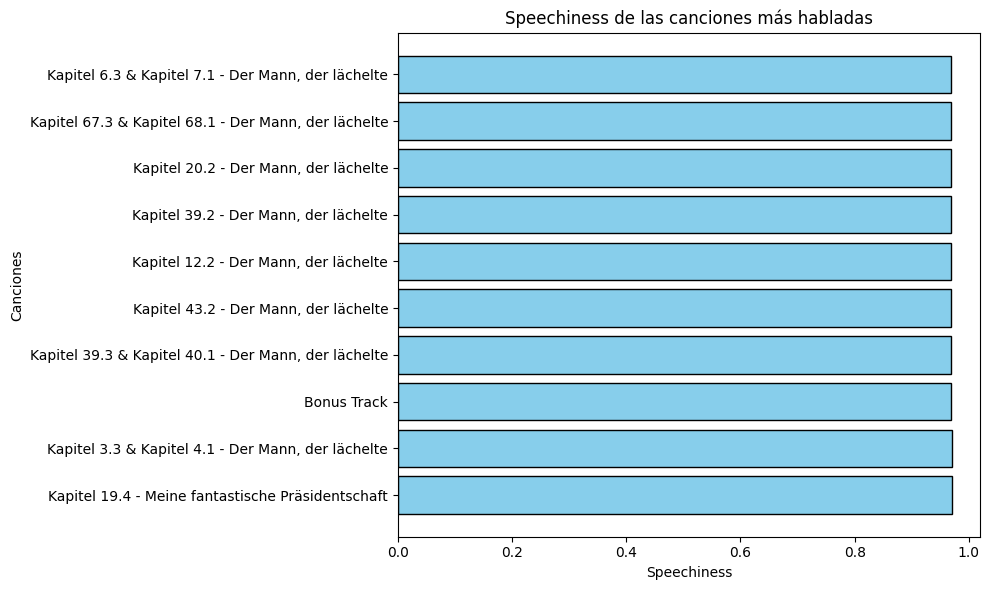

In [40]:
provider = ElasticSearchProvider()
response = provider.showSongsWhitMostSpeech()
if response:
    songs = [hit['_source']['track_name'] for hit in response['hits']['hits']]
    speechiness = [hit['_source']['speechiness'] for hit in response['hits']['hits']]
    plt.figure(figsize=(10, 6))
    plt.barh(songs, speechiness, color='skyblue', edgecolor='black')
    plt.xlabel('Speechiness')
    plt.ylabel('Canciones')
    plt.title('Speechiness de las canciones más habladas')
    plt.tight_layout()
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

## **12. Distribución de los valores de "time_signature"**

Busca en **Elasticsearch** la distribución de los valores de *time_signature* (firma de tiempo) presentes en las canciones, mostrando las cantidades para los valores más comunes.

Solo muestra los diferentes valores de *time_signature* y su cantidad de ocurrencias.

La función asigna dinámicamente el método a la clase `ElasticSearchProvider` para asegurar que funcione correctamente.


In [41]:
def showTimeSignature(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 0,
                    "aggs": {
                        "time_signature_distribution": {
                        "terms": {
                            "field": "time_signature",
                            "size": 5  
                        }
                        }
                    }
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
            
ElasticSearchProvider.showTimeSignature=showTimeSignature

## **Visualización**

Este código genera un gráfico donde podemos ver la variacion entre los compaces de todas las canciones.

1. Se procesa el resultado obtenido de ElasticSearch.
2. Se visualizan los resultados en un gráfico.


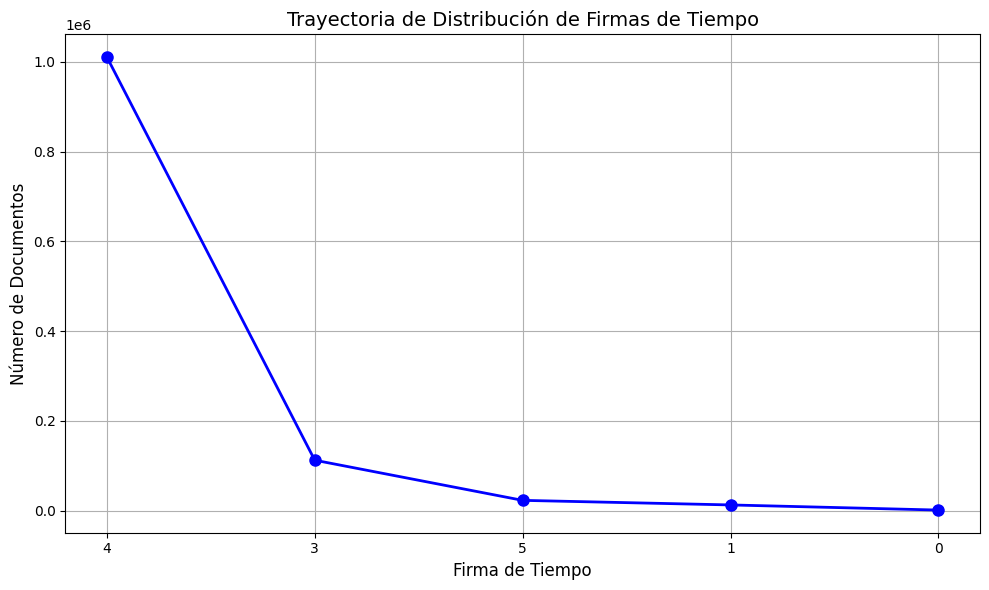

In [42]:
provider = ElasticSearchProvider()
response = provider.showTimeSignature()
if response:
    time_signatures = [bucket['key'] for bucket in response['aggregations']['time_signature_distribution']['buckets']]
    doc_counts = [bucket['doc_count'] for bucket in response['aggregations']['time_signature_distribution']['buckets']]
    plt.figure(figsize=(10, 6))
    plt.plot(time_signatures, doc_counts, marker='o', linestyle='-', color='b', markersize=8, linewidth=2)
    plt.title('Trayectoria de Distribución de Firmas de Tiempo', fontsize=14)
    plt.xlabel('Firma de Tiempo', fontsize=12)
    plt.ylabel('Número de Documentos', fontsize=12)
    plt.tight_layout()
    plt.grid(True)
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

## **13. Top 10 canciones con mayor "instrumentalness"**

Busca en **Elasticsearch** las 10 canciones con mayor nivel de *instrumentalness* (nivel de instrumentalidad), ordenadas de mayor a menor.

Solo muestra el nombre de la canción, el artista y el nivel de *instrumentalness*.

La función asigna dinámicamente el método a la clase `ElasticSearchProvider` para asegurar que funcione correctamente.


In [43]:
def showInstrumental(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 10,
                    "sort": [
                        {
                        "instrumentalness": {
                            "order": "desc"
                        }
                        }
                    ],
                    "_source": ["track_name", "artist_name", "instrumentalness"]
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")

ElasticSearchProvider.showInstrumental=showInstrumental

## **Visualización**

Este código genera un gráfico donde podemos las canciones cuyo indice instrumental es mayor.

1. Se procesa el resultado obtenido de ElasticSearch.
2. Se visualizan los resultados en un gráfico de barras horizontal.


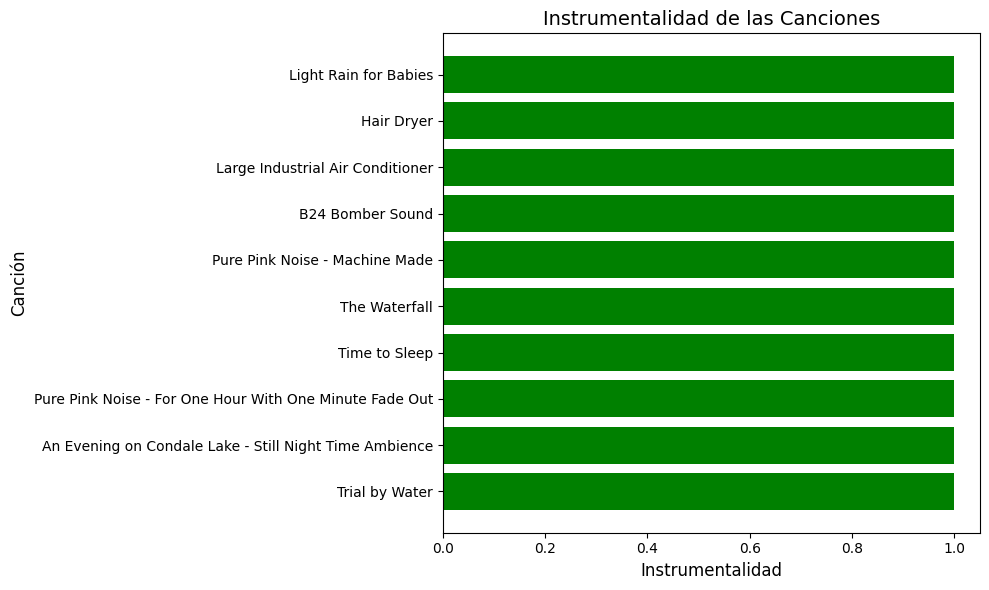

In [44]:
provider = ElasticSearchProvider()
response = provider.showInstrumental()
if response:
    track_names = [hit['_source']['track_name'] for hit in response['hits']['hits']]
    instrumentalness = [hit['_source']['instrumentalness'] for hit in response['hits']['hits']]
    plt.figure(figsize=(10, 6))
    plt.barh(track_names, instrumentalness, color='green')
    plt.title('Instrumentalidad de las Canciones', fontsize=14)
    plt.xlabel('Instrumentalidad', fontsize=12)
    plt.ylabel('Canción', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

## **14. Las 10 canciones más populares**

Busca en **Elasticsearch** las 10 canciones más populares, ordenadas de mayor a menor por su nivel de *popularity*.

Solo muestra el nombre de la canción, el artista y el nivel de *popularity*.

La función asigna dinámicamente el método a la clase `ElasticSearchProvider` para asegurar que funcione correctamente.


In [45]:
def showMorePopularitySongs(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 10,
                    "sort": [
                        {
                        "popularity": {
                            "order": "desc"
                        }
                        }
                    ],
                    "_source": ["track_name", "artist_name", "popularity"]
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")
            
ElasticSearchProvider.showMorePopularitySongs=showMorePopularitySongs

## **Visualización**

Este código genera un gráfico donde podemos ver laS canciones mas populares en general de todo el dataset.

1. Se procesa el resultado obtenido de ElasticSearch.
2. Se visualizan los resultados en un gráfico de barras horizontal.


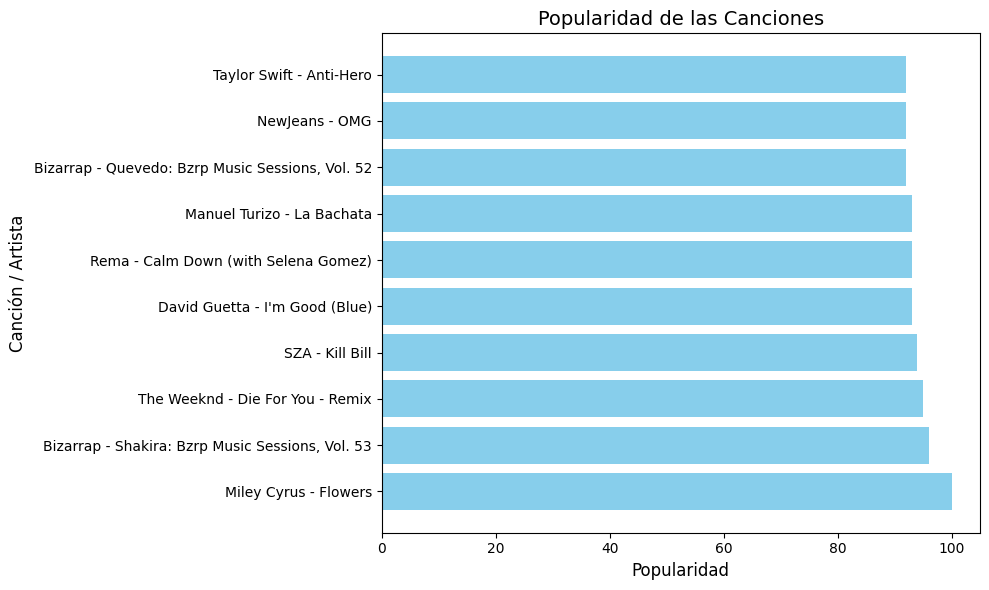

In [46]:
provider = ElasticSearchProvider()
response = provider.showMorePopularitySongs()
if response:
    track_names = [f"{hit['_source']['artist_name']} - {hit['_source']['track_name']}" for hit in response['hits']['hits']]
    popularity = [hit['_source']['popularity'] for hit in response['hits']['hits']]
    plt.figure(figsize=(10, 6))
    plt.barh(track_names, popularity, color='skyblue')
    plt.title('Popularidad de las Canciones', fontsize=14)
    plt.xlabel('Popularidad', fontsize=12)
    plt.ylabel('Canción / Artista', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No se obtuvo respuesta válida.")

## **15. Las 10 canciones más largas**

Busca en **Elasticsearch** las 10 canciones con mayor duración, ordenadas de mayor a menor por su campo *duration_ms* (duración en milisegundos).

Solo muestra el nombre de la canción, el artista y la duración de la canción en milisegundos.

La función asigna dinámicamente el método a la clase `ElasticSearchProvider` para asegurar que funcione correctamente.


In [47]:
def showMoreLongSongs(self):
        try:
            response=self.connection.search(
                index=self.index,
                body={
                    "size": 10,
                    "sort": [
                        {
                        "duration_ms": {
                            "order": "desc"
                        }
                        }
                    ],
                    "_source": ["track_name", "artist_name", "duration_ms"]
                    }
            )
            return response
            
        except Exception as e:
            print(f"Error: {str(e)}")

ElasticSearchProvider.showMoreLongSongs=showMoreLongSongs

## **Visualización**

Este código genera un gráfico donde podemos ver las canciones con mayor duracion de todo el dataset..

1. Se procesa el resultado obtenido de ElasticSearch.
2. Se visualizan los resultados en un gráfico de barras horizontal.


C:\Users\Manuel\AppData\Local\Temp\ipykernel_4204\3794863814.py:11: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


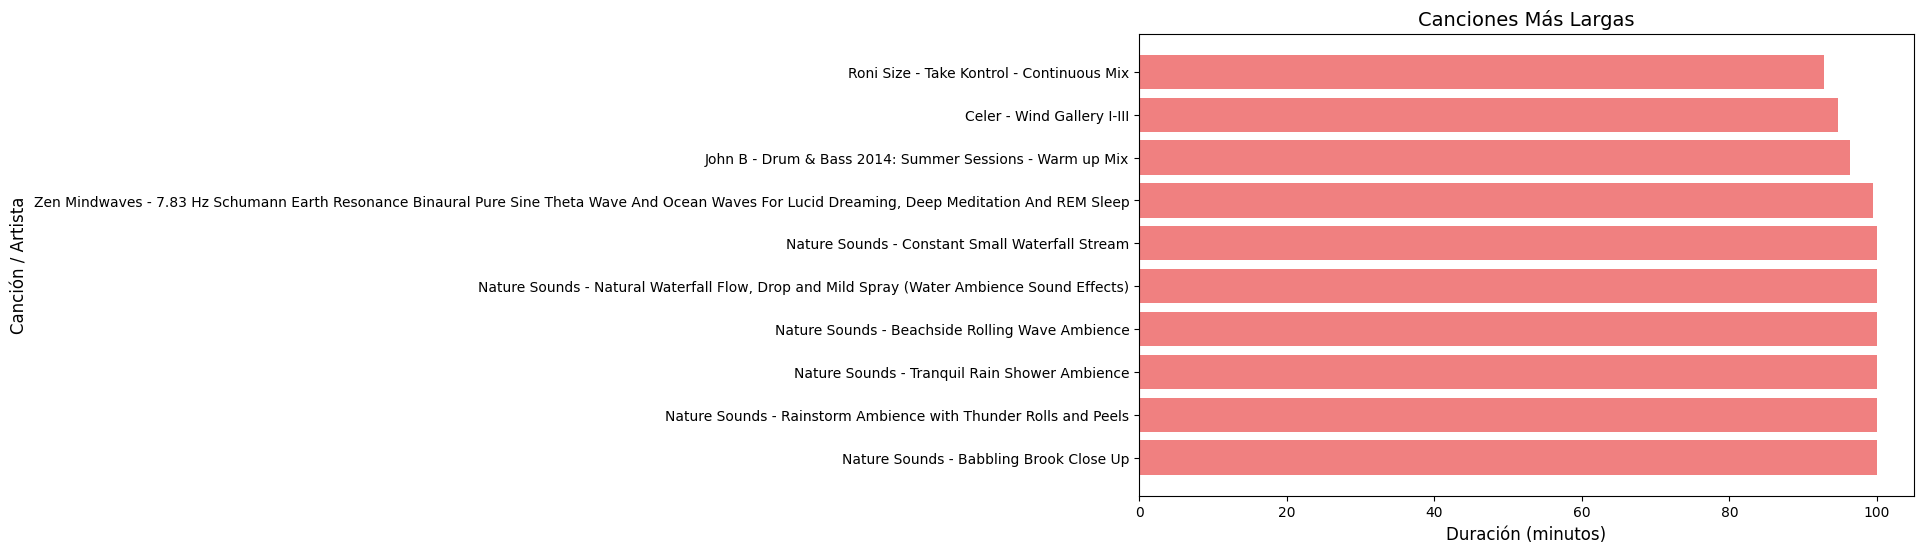

In [48]:
provider = ElasticSearchProvider()
response = provider.showMoreLongSongs()
if response:
    track_names = [f"{hit['_source']['artist_name']} - {hit['_source']['track_name']}" for hit in response['hits']['hits']]
    durations = [hit['_source']['duration_ms'] / 60000 for hit in response['hits']['hits']]
    plt.figure(figsize=(10, 6))
    plt.barh(track_names, durations, color='lightcoral')
    plt.title('Canciones Más Largas', fontsize=14)
    plt.xlabel('Duración (minutos)', fontsize=12)
    plt.ylabel('Canción / Artista', fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("No se obtuvo respuesta válida.")